## Some comparisons of filtering and smoothing (can be with or without the viewer)

### Instruction reminders for your tasks 3) and 4)
**You must implement your filtering / smoothing in the FilterSmoother class in the file _Filters.py_. This means also that you can use the visualisation through the Localizer, but you can call filter / smooth also directly from here, without the Localizer. Note also, that you must make use of the given models and the robot simulator in RobotSim! Inspect _Localizer.py_ for inspiration on how to do that!**

### Hint:
You can of course implement the different evaluations (task 4) in a regular .py-file and run Python from the command line! If you use the notebook, you need to restart the kernel after every change in a .py-file that is called from the notebook.


In [13]:
# In this cell, you can write your own "main" to run and evaluate your 
# implementation without using the visualisation (should be considerably faster!)

from models import *
from models.ObservationModel_NUF import ObservationModel
from models.ObservationModel_UF import ObservationModelUF

from Filters import FilterSmoother

import numpy as np
import matplotlib.pyplot as plt # for plotting the average errors in comparison
import random

print("Libraires imported successfully.")


Libraires imported successfully.



 Thus, measure the distance between true location and estimate by using the Manhattan distance

In [14]:
def manhattan_distance(x,y):
    return abs(x[0]-y[0]) + abs(x[1]-y[1])

def distance_true_estimate(sm, true_states, pos_estimate):
    true_pos = [sm.state_to_position(state) for state in true_states]
    return [manhattan_distance(true_pos[i], pos_estimate[i]) for i in range(len(true_states))]

def state_to_position_estimate(sm,f_state):
    """
    Convert the state belief (over all states = rows * cols *4) to a position belief (over grid cells, rows*cols) 
    by summing over the 4 headings for each position.
    """
    rows, cols, head = sm.get_grid_dimensions()
    pos_est = np.zeros(rows*cols)

    for s in range(sm.get_num_of_states()):
        r = sm.state_to_reading(s) 
        pos_est[r] += f_state[s]
    return pos_est


def estimate_position_from_belief(sm, f_state):
    """
    Get the position estimate from the belief by taking the position with the highest probability.
    """
    pos_est = state_to_position_estimate(sm, f_state)
    return sm.reading_to_position(np.argmax(pos_est))

def running_average(x):
    """
    Compute the running average of a list of numbers.
    """
    return np.cumsum(x) / np.arange(1, len(x) + 1)

In [15]:
def stimulate_robot_trajectory_and_sensor_readings(rows,cols,steps,seed):
    
    # For reproducibility, set the random seed
    random.seed(seed)
    np.random.seed(seed)

    sm = StateModel(rows, cols)
    tm = TransitionModel(sm)
    #om = ObservationModel(sm) -- Observation model is chosen outside of this function, so we can test different ones

    # robot start state is randomly chosen, get the same start state for each Statemodel setup by using the same seed
    robot = RobotSim(random.randrange(sm.get_num_of_states()), sm)

    true_states = []

    for _ in range(steps):
        next_state = robot.move_once(tm)
        true_states.append(next_state)
    
    return sm,tm, true_states

def generate_sensor_readings(sm,om,true_states,seed):
    """
    Generate one reproducible sequence of sensor readings for the given true states and observation model, 
    using the same seed for reproducibility.
    """

    rdg = random.Random(seed)  # create a local random generator with the given seed

    sensor_readings = []

    for state in true_states:
        rand = rdg.random()  # use the local random generator
        probSum = 0.0

        for i in range(sm.get_num_of_readings()-1):
            probSum += om.get_o_reading_state(i,state)
            if probSum > rand:
                sensor_readings.append(i)
                break
        else:
            sensor_readings.append(None)

    return sensor_readings


In [16]:
def run_forward_filter(tm, om, sm, sensor_readings):
    """
    Return list of position estimates and list of beliefs f_t
    """
    f_probs = np.ones(sm.get_num_of_states()) / sm.get_num_of_states()  # uniform initial belief

    HMM = FilterSmoother(f_probs, tm=tm, om=om, sm=sm)

    f_history = []
    pos_est = []
    for r in sensor_readings:
        f_probs = HMM.filter(r, f_probs)
        f_history.append(f_probs.copy())
        pos_est.append(estimate_position_from_belief(sm, f_probs))
    
    return pos_est, f_history

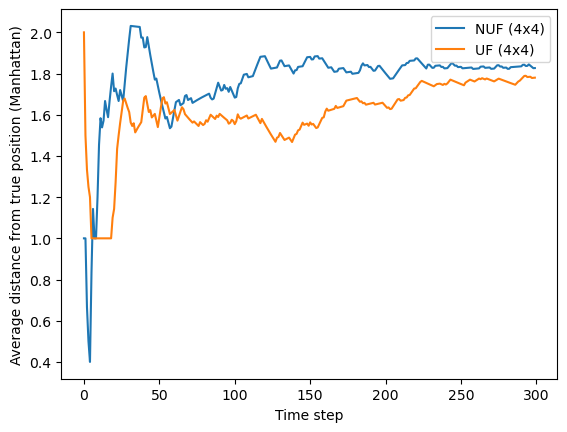

In [21]:
rows, cols = 4,4
steps = 300
seed = 8

sm,tm, true_states = stimulate_robot_trajectory_and_sensor_readings(rows,cols,steps,seed)

om_nuf = ObservationModel(sm)
om_uf = ObservationModelUF(sm)

reading_nuf = generate_sensor_readings(sm,om_nuf,true_states,seed)
reading_uf = generate_sensor_readings(sm,om_uf,true_states,seed)

pos_est_nuf, _ = run_forward_filter(tm, om_nuf, sm, reading_nuf)
pos_est_uf, _ = run_forward_filter(tm, om_uf, sm, reading_uf)

d_nuf = distance_true_estimate(sm, true_states, pos_est_nuf)
d_uf = distance_true_estimate(sm, true_states, pos_est_uf)

plt.figure()
plt.plot(running_average(d_nuf), label='NUF (4x4)')
plt.plot(running_average(d_uf), label='UF (4x4)')
plt.xlabel('Time step')
plt.ylabel('Average distance from true position (Manhattan)')
plt.legend()
plt.show()

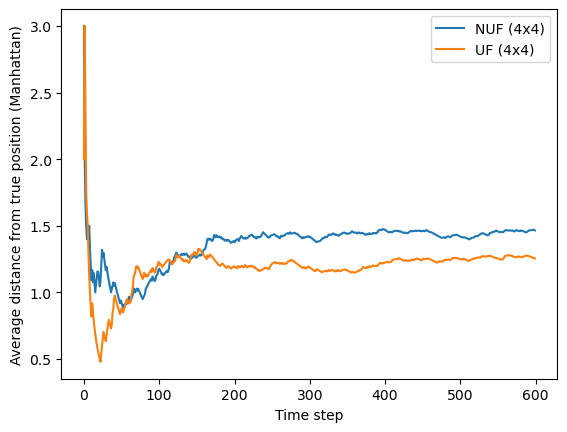

In [26]:
rows, cols = 10,10
steps = 600
seed = 25

sm,tm, true_states = stimulate_robot_trajectory_and_sensor_readings(rows,cols,steps,seed)

om_nuf = ObservationModel(sm)
om_uf = ObservationModelUF(sm)

reading_nuf = generate_sensor_readings(sm,om_nuf,true_states,seed)
reading_uf = generate_sensor_readings(sm,om_uf,true_states,seed)

pos_est_nuf, _ = run_forward_filter(tm, om_nuf, sm, reading_nuf)
pos_est_uf, _ = run_forward_filter(tm, om_uf, sm, reading_uf)

d_nuf = distance_true_estimate(sm, true_states, pos_est_nuf)
d_uf = distance_true_estimate(sm, true_states, pos_est_uf)

plt.figure()
plt.plot(running_average(d_nuf), label='NUF (4x4)')
plt.plot(running_average(d_uf), label='UF (4x4)')
plt.xlabel('Time step')
plt.ylabel('Average distance from true position (Manhattan)')
plt.legend()
plt.show()

In [25]:

def state_belief_to_position_belief(sm, f_state):
    """Sum over the 4 headings so each grid cell gets one probability (like GUI)."""
    rows, cols, head = sm.get_grid_dimensions()
    pos = np.zeros(rows * cols, dtype=float)
    for s in range(sm.get_num_of_states()):
        r = sm.state_to_reading(s)   # reading index for position (x,y)
        pos[r] += f_state[s]
    return pos

def manhattan(p1, p2):
    return abs(p1[0]-p2[0]) + abs(p1[1]-p2[1])

# ------------------- SETTINGS -------------------
rows, cols = 8, 8
steps = 100   # do 200, but you can look at first 100
seed = 1234
random.seed(seed)
np.random.seed(seed)

# ------------------- MODELS -------------------
sm = StateModel(rows, cols)

om = ObservationModel_NUF(sm)  # NUF

# robot start
start_state = random.randrange(sm.get_num_of_states())
robot = RobotSim(start_state, sm)

# initial belief: uniform over all poses
S = sm.get_num_of_states()
f = np.ones(S) / S

fs = FilterSmoother(f.copy(), tm, om, sm)  # your constructor signature

# ------------------- RUN + EVALUATE -------------------
correct = 0
distances = []

for t in range(steps):
    # 1) move true robot
    true_state = robot.move_once(tm)
    true_pos = sm.state_to_position(true_state)

    # 2) sense
    reading = robot.sense_in_current_state(om)  # int or None

    # 3) forward filter update
    f = fs.filter(reading, f)

    # convert belief over poses -> belief over positions (sum headings)
    pos_bel = state_belief_to_position_belief(sm, f)

    # estimated position = argmax over positions
    est_reading = int(np.argmax(pos_bel))
    est_pos = sm.reading_to_position(est_reading)

    # accuracy
    if est_pos == true_pos:
        correct += 1

    # manhattan distance
    distances.append(manhattan(est_pos, true_pos))

    # print a quick checkpoint at 100
    if t == 99:
        print("After 100 steps:")
        print("  % correct =", correct/100)
        print("  avg Manhattan distance =", float(np.mean(distances)))

print("\nFinal:")
print("  % correct =", correct/steps)
print("  avg Manhattan distance =", float(np.mean(distances)))


TypeError: 'module' object is not callable